In [178]:
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.fft import fft, ifft
PATH = "apnea-ecg-database-1.0.0/"

SAMPFROM = 0
SAMPTO = 5000

In [ ]:
record_ecg = wfdb.rdrecord(PATH + "a01")#, sampfrom=SAMPFROM, sampto=SAMPTO)
annotation = wfdb.rdann(PATH+ "a01", 'qrs')#, sampfrom=SAMPFROM, sampto=SAMPTO, shift_samps=True)

df2 = record_ecg.to_dataframe()
df2['time'] = df2.index.microseconds / 1000 + df2.index.seconds * 1000
df2 = df2[['time', 'ECG']]
df2.reset_index(drop=True, inplace=True)
df2

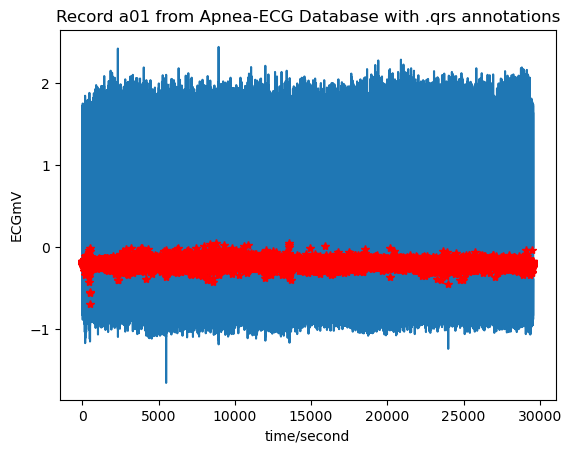

In [180]:
wfdb.plot_wfdb(record=record_ecg, annotation=annotation,
               title='Record a01 from Apnea-ECG Database with .qrs annotations',
               time_units='seconds')

[     34     123     207 ... 2956283 2956363 2956445]
[89. 84. 83. ... 81. 80. 82.]


Text(0.5, 1.0, 'Fragment zapisu EKG dla jednego uderzenia')

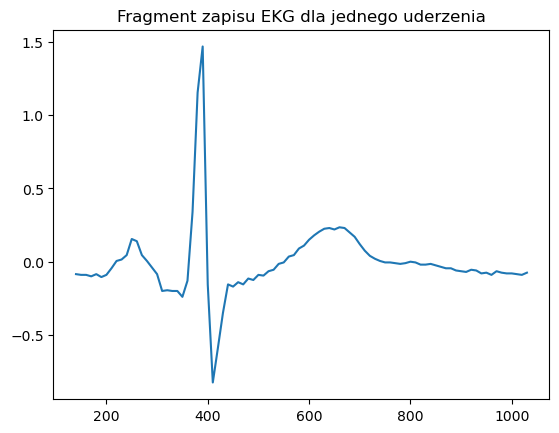

In [181]:
#przetwarzanie danych timeeeeeeee
print(annotation.sample)
num_of_beats = annotation.sample.size - 1
offset_l = 20
offset_r = 70

temp = np.zeros(num_of_beats)

for beat in range(num_of_beats):
    temp[beat] = annotation.sample[beat+1] - annotation.sample[beat]
print(temp)

#test czy to pojedyncze bicie

plt.plot(df2['time'][34 - offset_l:34+offset_r], df2['ECG'][34 - offset_l:34 + offset_r])
plt.title('Fragment zapisu EKG dla jednego uderzenia')

In [182]:
beats = np.zeros((num_of_beats, offset_l+offset_r))

for beat in range(num_of_beats):
    start_pos = annotation.sample[beat]
    beats[beat] = df2['ECG'][start_pos-offset_l:start_pos+offset_r]



In [183]:
#jakas zabawa
# qrs_inds = processing.qrs.gqrs_detect(sig=record_ecg.p_signal[:,0], fs=200)
# qrs_inds = (1 / record_ecg.fs) * qrs_inds
# # print(qrs_inds.size)
# # Utwórz nowy wykres i oś
# signal = record_ecg.p_signal[:, 0]
# time = (1 / record_ecg.fs) * np.arange(len(signal))

# # Utwórz nowy wykres
# fig, ax = plt.subplots()

# # Wyświetl sygnał EKG na wykresie
# ax.plot(time, signal)

# # Wygeneruj i wyrysuj dodatkowe punkty na tym samym wykresie
# ax.plot(qrs_inds, np.zeros(qrs_inds.size), 'ro')  # 'ro' oznacza czerwone kropki

# # Wyświetl wykres z dodatkowymi punktami i etykietami
# plt.show()

In [184]:
scaler = StandardScaler()
scaler.fit(beats)
X_scaled = scaler.transform(beats)

In [185]:
pca = decomposition.PCA(n_components=4)
X_transformed = pca.fit_transform(X_scaled)

In [186]:
eigen_vectors = pca.components_
eigen_values = pca.explained_variance_
# print(eigen_vectors)
print(eigen_values)

[16.202779   10.47575015  9.76744916  6.7930886 ]


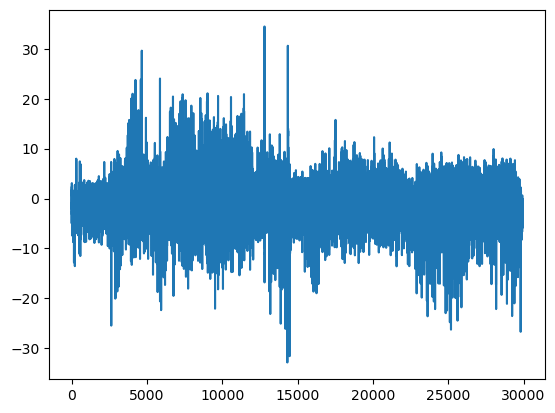

In [187]:
# plt.plot(df2.ECG)
plt.plot(X_transformed[:,0])
# plt.plot(X_transformed[:,1])
# plt.plot(X_transformed[:,2])
# plt.plot(X_transformed[:,3])
# plt.xlim(0, 100)

In [188]:
X_transformed

array([[-2.54925448, -2.51635346,  1.6726564 , -5.17945729],
       [-2.73395212, -3.81821239,  3.23096473, -4.29694636],
       [-3.20210696, -4.14155569,  2.4008219 , -5.74967805],
       ...,
       [-4.60338383, -4.37289019, -1.58633505, -5.9696025 ],
       [-5.90113613, -8.85001315, -1.96589804, -1.96702197],
       [-4.50453185, -6.25264772, -3.27720776, -3.9946083 ]])

In [189]:
record = wfdb.rdrecord(PATH + "a01r", sampfrom=SAMPFROM, sampto=SAMPTO)

df = record.to_dataframe()
df['time'] = df.index.microseconds / 1000 + df.index.seconds * 1000
df = df[['time', 'Resp C', 'Resp A', 'Resp N']]
df.reset_index(drop=True, inplace=True)
df.head()

,time,Resp C,Resp A,Resp N
0,0.0,-0.1015,-0.3446,0.23545
1,10.0,-0.1025,-0.3455,0.23640
2,20.0,-0.1035,-0.3464,0.23735
3,30.0,-0.1045,-0.3473,0.23830
4,40.0,-0.1055,-0.3482,0.23925


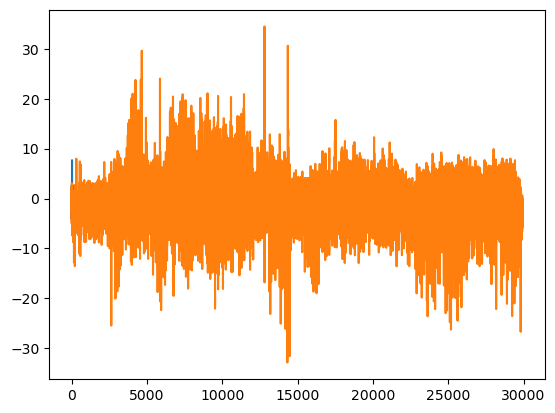

In [190]:
#plt.plot(df2['time'], df2['ECG'])
# plt.plot(df['time'], df['Resp C'])
plt.plot(df['time']/1000, df['Resp A']*10)
# plt.plot(df['time'], df['Resp N'])


plt.plot(X_transformed[:,0])

In [191]:
y_resp_norm = (df['Resp A']-min(df['Resp A'])) / max(df['Resp A']-min(df['Resp A']))
y_PCA_norm = (X_transformed[:,0]-min(X_transformed[:,0])) / max(X_transformed[:,0]-min(X_transformed[:,0]))
coeff = y_resp_norm.size/100 / y_PCA_norm.size

Text(0.5, 1.0, 'PCA nieprzeskalowane')

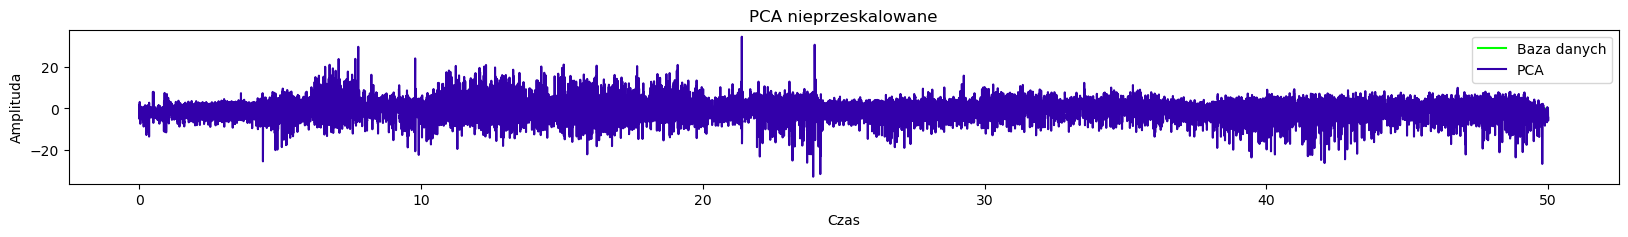

In [192]:
plt.figure(figsize=(20, 2))
plt.plot(np.arange(X_transformed[:,0].size)*coeff, X_transformed[:,0], label='PCA', color=('#3300AA'))
plt.plot(df['time']/1000, df['Resp A'], label='Baza danych', color='lime')
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('PCA nieprzeskalowane')

<Figure size 2000x200 with 0 Axes>

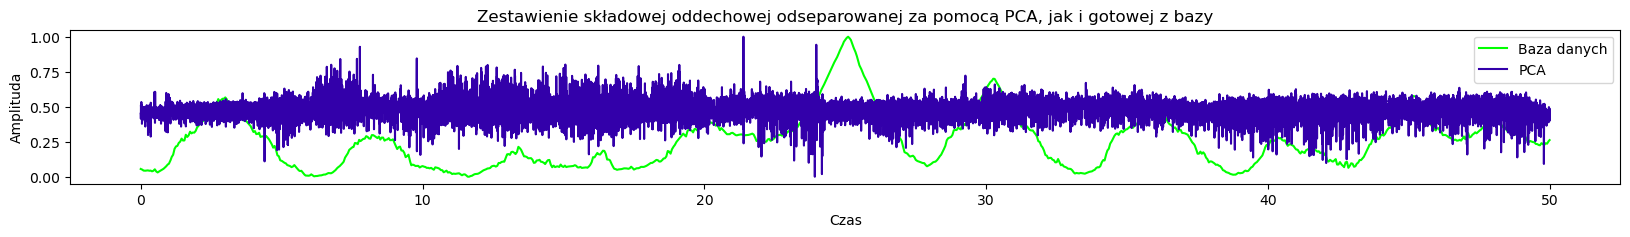

<Figure size 2000x200 with 0 Axes>

In [193]:
plt.figure(figsize=(20, 2))
plt.plot(np.arange(X_transformed[:,0].size)*coeff, y_PCA_norm, label='PCA', color=('#3300AA'))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title('Zestawienie składowej oddechowej odseparowanej za pomocą PCA, jak i gotowej z bazy')
# print(scipy.signal.coherence(y_resp_norm, y_PCA_norm))
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_PCA_norm)

In [194]:
kpca = decomposition.KernelPCA(n_components=4, kernel='cosine')
X_ktransformed = kpca.fit_transform(X_scaled)

KeyboardInterrupt: 

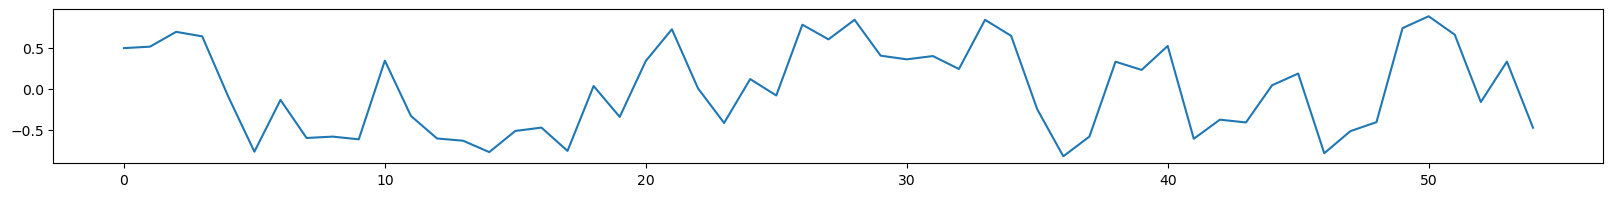

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(X_ktransformed[:,0])

In [ ]:
y_kPCA_norm = (X_ktransformed[:,0]-min(X_ktransformed[:,0])) / max(X_ktransformed[:,0]-min(X_ktransformed[:,0]))

<Figure size 2000x200 with 0 Axes>

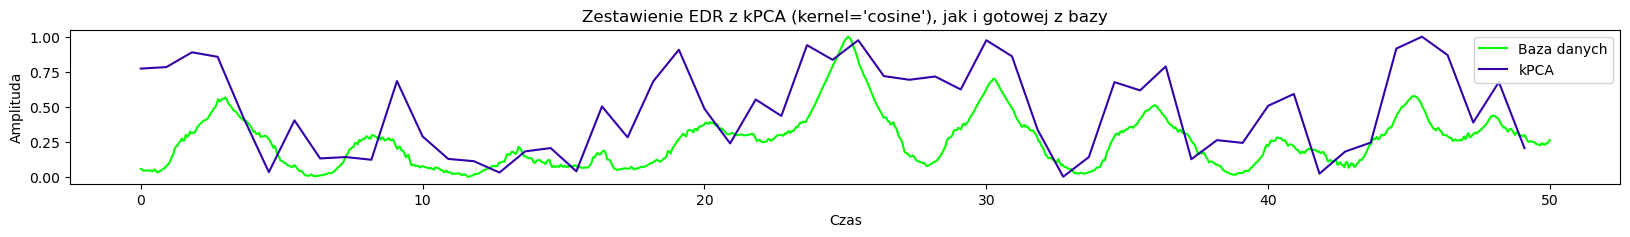

<Figure size 2000x200 with 0 Axes>

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_kPCA_norm, label='kPCA', color=('#3300AA'))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z kPCA (kernel=\'{kpca.kernel}\'), jak i gotowej z bazy")
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_kPCA_norm)

In [ ]:
ica = decomposition.FastICA(n_components=4)
X_ica_transformed = ica.fit_transform(X_scaled)
ica_chosen = X_ica_transformed[:,2]

c:\Users\mechl\.conda\envs\lab3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


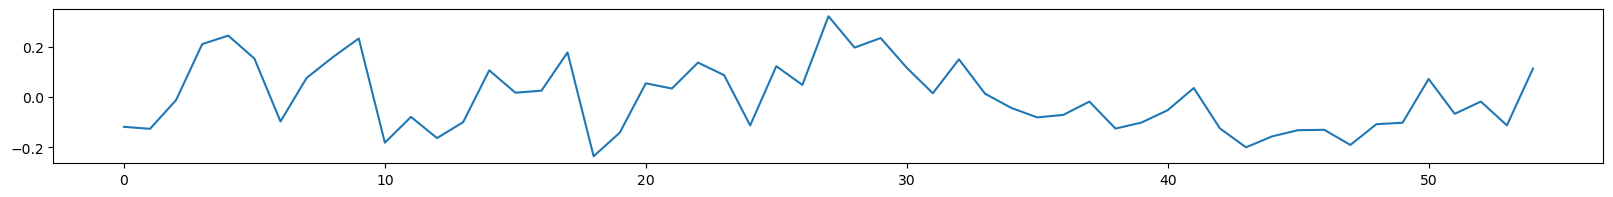

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(ica_chosen)

In [ ]:
y_ICA_norm = (ica_chosen-min(ica_chosen)) / max(ica_chosen-min(ica_chosen))

<Figure size 2000x200 with 0 Axes>

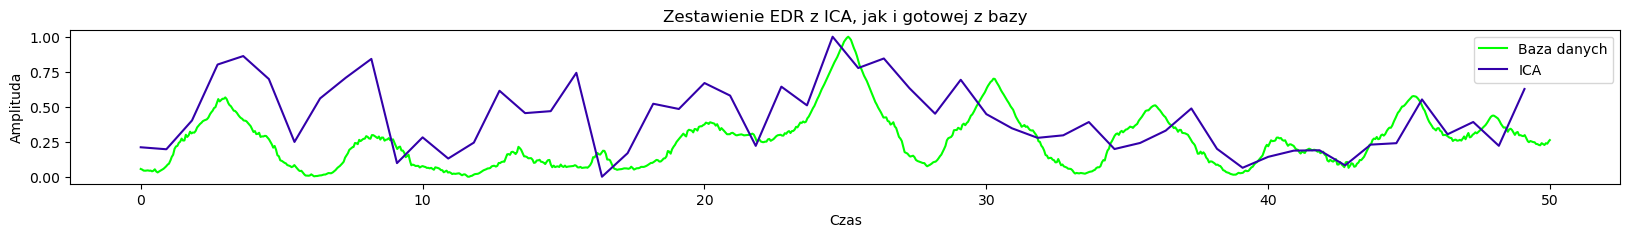

<Figure size 2000x200 with 0 Axes>

In [ ]:
plt.figure(figsize=(20, 2))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(ica_chosen.size)*coeff, y_ICA_norm, label='ICA', color=('#3300AA'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR z ICA, jak i gotowej z bazy")
plt.figure(figsize=(20, 2))
# plt.cohere(y_resp_norm, y_ICA_norm)

Text(0.5, 1.0, 'Zestawienie EDR wykonanymi różnymi metodami, jak i gotowej z bazy')

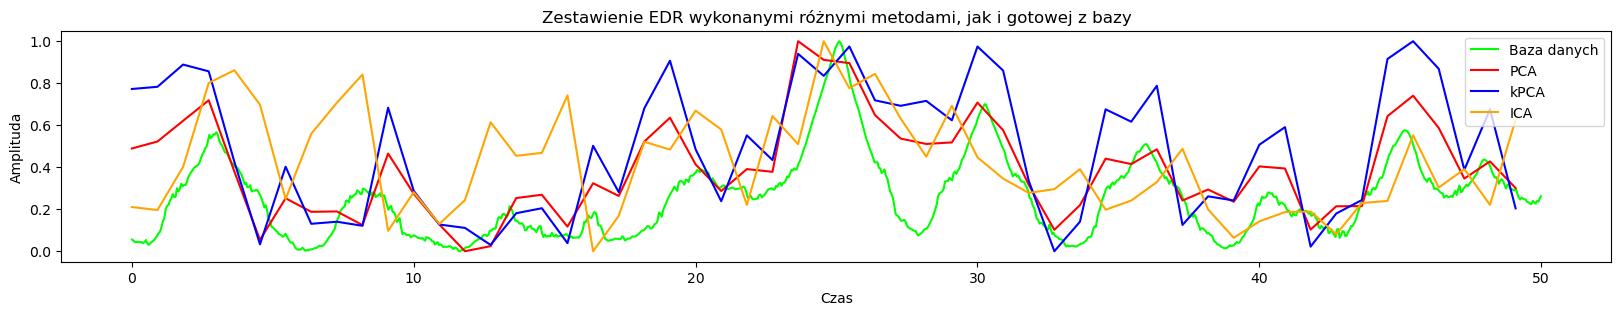

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(df['time']/1000, y_resp_norm, label='Baza danych', color='lime')
plt.plot(np.arange(X_transformed[:,0].size)*coeff, y_PCA_norm, label='PCA', color=('red'))
plt.plot(np.arange(X_ktransformed[:,0].size)*coeff, y_kPCA_norm, label='kPCA', color=('blue'))
plt.plot(np.arange(ica_chosen.size)*coeff, y_ICA_norm, label='ICA', color=('orange'))
plt.legend()

plt.xlabel('Czas')
plt.ylabel('Amplituda')
plt.title(f"Zestawienie EDR wykonanymi różnymi metodami, jak i gotowej z bazy")

In [ ]:
# from scipy.fftpack import fftfreq
# N = SAMPTO-SAMPFROM
# # sample spacing
# T = 1.0 / 100.0

# yf = fft(np.array(y_resp_norm))
# xf = fftfreq(N, T)[:N//2]
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.grid()
# plt.show()

In [ ]:
pca_res = scipy.signal.resample(y_PCA_norm, num=y_resp_norm.size)
kpca_res = scipy.signal.resample(y_kPCA_norm, num=y_resp_norm.size)
ica_res = scipy.signal.resample(y_ICA_norm, num=y_resp_norm.size)

scipy.stats.pearsonr(y_resp_norm, pca_res), scipy.stats.pearsonr(y_resp_norm, kpca_res), scipy.stats.pearsonr(y_resp_norm, ica_res)

(PearsonRResult(statistic=0.73293538019699, pvalue=0.0),
 PearsonRResult(statistic=0.6401604398327871, pvalue=0.0),
 PearsonRResult(statistic=0.4835761455559457, pvalue=1.8784357378883515e-291))